In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [38]:
# import data
remote_sensing_data = pd.read_csv('./Data/without_cloud_mask/Remote_data.csv',parse_dates=['Date'])

# Determine the sys_cols that are not use as features
sys_cols = ['Date','NAME','Area']

# remove the unnecessary cols
rs_data = remote_sensing_data.drop(sys_cols,1)
rs_data.head()

,Albedo_inst,AvgSurfT_inst,CanopInt_inst,ECanop_tavg,ESoil_tavg,Evap_tavg,LWdown_f_tavg,Lwnet_tavg,PotEvap_tavg,Psurf_f_inst,...,SoilMoi40_100cm_inst,SoilTMP0_10cm_inst,SoilTMP100_200cm_inst,SoilTMP10_40cm_inst,SoilTMP40_100cm_inst,Swnet_tavg,Tair_f_inst,Tveg_tavg,Wind_f_inst,NDVI
0,18.423127,278.973359,0.042567,4.106985,17.523134,0.000012,278.508345,-61.399424,98.406877,101428.941808,...,160.006416,279.448185,283.110664,279.922253,281.211210,71.784304,280.512647,8.447369,3.821237,0.387425
1,18.577235,278.230504,0.020431,2.967367,10.439595,0.000008,277.982970,-58.126265,58.183541,101769.232633,...,159.590881,278.373212,283.031702,279.850869,281.178303,80.134545,279.461531,5.747781,1.777187,0.387425
2,18.459500,275.109867,0.000000,0.003391,21.374002,0.000012,238.130987,-81.963728,123.216960,102133.057618,...,159.230357,276.877828,282.953398,279.476251,281.104734,97.947352,275.602725,6.810954,4.485382,0.120019
3,18.389800,275.693528,0.000000,0.001083,9.070885,0.000005,258.268999,-65.447586,53.365314,102221.879024,...,158.746793,276.083430,282.874753,278.914702,280.952225,92.684368,276.159525,4.729566,2.708520,0.105565
4,18.429593,278.256112,0.000608,0.196932,12.183381,0.000007,307.032400,-30.357620,73.595106,102135.807564,...,158.385845,277.783973,282.790518,278.777222,280.761177,77.712049,277.894870,5.142580,4.319664,0.183901


##### See if there are features that have a very low variance

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

In [4]:
# stadardize the data
scaler = MinMaxScaler()
standard_data = scaler.fit_transform(rs_data)
rs_data = pd.DataFrame(standard_data,columns=rs_data.columns)

In [5]:
# compute the variance of each feature
variance_filter = VarianceThreshold()
variance_filter.fit(rs_data)

# find the features with a >0.01 variance
keep_cols = rs_data.columns[variance_filter.variances_ > 0.01]

# subset the original data
high_var = rs_data[keep_cols]

##### See if some features are highly correated

In [6]:
# compute the correlation between features
corr = high_var.corr()

<AxesSubplot:>

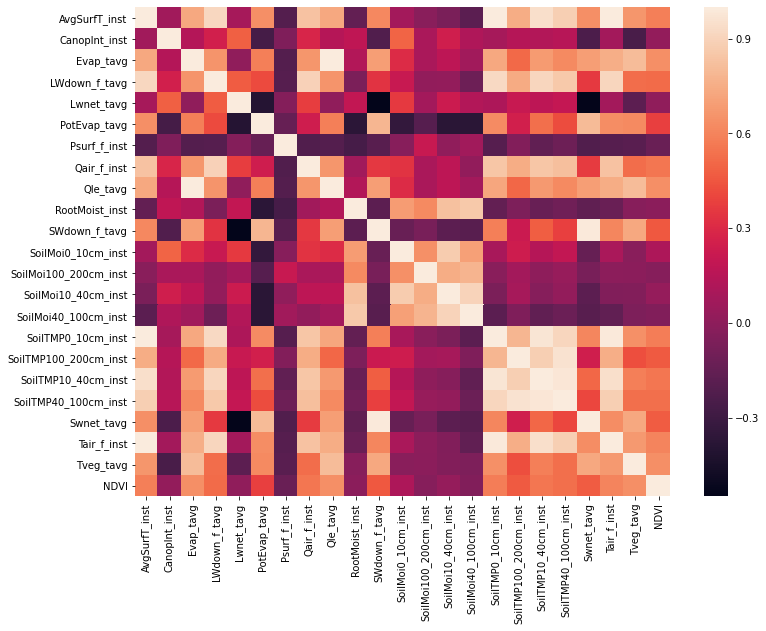

In [7]:
# plot the correlation 
plt.figure(figsize=(12,9))
sns.heatmap(corr)

In [8]:
# function to loop through the crrelation matrix and 
# find out the feature with high variance (> threshold)

def get_high_correlation(data,threshold):
    
    corr_col = set()
    corr_mat = data.corr()
    
    # loop through row
    for i in range(len(corr_mat)):
        # fetch the ith row of the corr_mat
        corr_arr = corr_mat.iloc[i,:]
        # convert the row into a list
        corr_arr_list = list(corr_arr)
        # remove the corr of a feature to itself
        corr_arr_list.pop(i)
        
        # if any of the correlation value for this feature is greater than threshold
        # then add it to the corr_col
        if (np.array(corr_arr_list)>threshold).sum() > 0:
            feature_name = corr_mat.columns[i]
            corr_col.add(feature_name)
            
    return corr_col

In [9]:
# get the features with high correlation with others
col_to_remove = get_high_correlation(high_var,0.85)

# remove these features
low_corr = high_var.drop(col_to_remove,1)

##### Save the selected features to drive

In [39]:
# cols to keep
cols_selected = ['Date','NAME'] + list(low_corr.columns)

# subset the original data
selected_data = remote_sensing_data[cols_selected]
selected_data.head()

,Date,NAME,CanopInt_inst,Lwnet_tavg,PotEvap_tavg,Psurf_f_inst,SoilMoi100_200cm_inst,Tveg_tavg,NDVI
0,2001-01-01,上蔡县,0.042567,-61.399424,98.406877,101428.941808,303.771669,8.447369,0.387425
1,2001-01-02,上蔡县,0.020431,-58.126265,58.183541,101769.232633,303.435322,5.747781,0.387425
2,2001-01-03,上蔡县,0.000000,-81.963728,123.216960,102133.057618,303.011240,6.810954,0.120019
3,2001-01-04,上蔡县,0.000000,-65.447586,53.365314,102221.879024,302.940471,4.729566,0.105565
4,2001-01-05,上蔡县,0.000608,-30.357620,73.595106,102135.807564,302.620990,5.142580,0.183901


In [70]:
# save the data to drive
selected_data.to_csv('./Data/without_cloud_mask/RS_data_selected.csv',index=False,encoding='utf-8-sig')